<a href="https://colab.research.google.com/github/mamirandamorante/SVHN/blob/main/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
import random
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Load the dataset from your Drive folder

train = loadmat('/content/gdrive/MyDrive/path/to/train_32x32.mat')
test = loadmat('/content/gdrive/MyDrive/path/to/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [4]:
#Extract the training and testing images and labels
X_train = train['X']
y_train = train['y']
X_test = test['X']
y_test = test['y']

print("Training Set", X_train.shape, y_train.shape)
print("Testing Set", X_test.shape, y_test.shape)

Training Set (32, 32, 3, 73257) (73257, 1)
Testing Set (32, 32, 3, 26032) (26032, 1)


In [5]:
# Calculate the total number of images
num_images = X_train.shape[3] + X_test.shape[3]
print("Total Number of Images in the dataset:", num_images)

Total Number of Images in the dataset: 99289


In [6]:
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

X_train = X_train / 255.0
X_test = X_test / 255.0

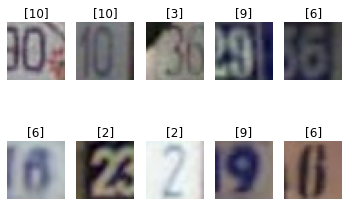

In [7]:
# Plot 10 training set images and its labels
for i in range(10):
    elde = random.randint(0,1000)
    plt.subplot(2,5,i+1)
    plt.title(str(y_train[elde]), fontsize=12) 
    plt.imshow(X_train[:,:,:,elde]) 
    plt.axis("off") 
plt.show()

In [8]:
#Convert trainint and test image sets from RGB to grayscale
X_train = np.average(X_train,axis = 2)
X_test = np.average(X_test,axis = 2)
print("Training Set", X_train.shape, y_train.shape)
print("Testing Set", X_test.shape, y_test.shape)

Training Set (32, 32, 73257) (73257, 1)
Testing Set (32, 32, 26032) (26032, 1)


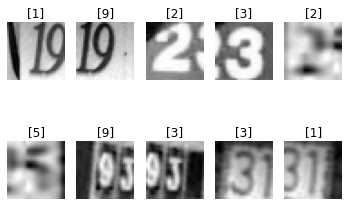

In [9]:
# Plot 10 training set images and its labels
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.title(str(y_train[i]), fontsize=12) 
    plt.imshow(X_train[:,:,i], cmap=plt.get_cmap('gray'))
    plt.axis("off") 
plt.show()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [10]:
X_train_mlp = np.moveaxis(X_train, -1, 0)
X_test_mlp = np.moveaxis(X_test, -1, 0)
X_train_mlp =X_train_mlp[..., np.newaxis]
X_test_mlp = X_test_mlp[..., np.newaxis]
print("Training Set", X_train_mlp.shape, y_train.shape)
print("Testing Set", X_test_mlp.shape, y_test.shape)

Training Set (73257, 32, 32, 1) (73257, 1)
Testing Set (26032, 32, 32, 1) (26032, 1)


In [11]:
def get_model(input_shape):
    model = Sequential([
        Dense(128,activation='relu',input_shape=input_shape,name='Dense1'),
        Dense(128,activation='relu',name='Dense2'),
        Flatten(name='Flatten'),
        Dense(64,activation='relu',name='Dense3'),
        Dense(11,activation='softmax',name='Dense4')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
model = get_model(X_train_mlp[0].shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 32, 32, 128)       256       
_________________________________________________________________
Dense2 (Dense)               (None, 32, 32, 128)       16512     
_________________________________________________________________
Flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
Dense3 (Dense)               (None, 64)                8388672   
_________________________________________________________________
Dense4 (Dense)               (None, 11)                715       
Total params: 8,406,155
Trainable params: 8,406,155
Non-trainable params: 0
_________________________________________________________________


In [13]:
#Callbacks ModelCheckpoint and EarlyStopping
def get_checkpoint_best_only():
    checkpoint_best_only_path = 'checkpoints_best_only/checkpoint'
    checkpoint_best_only = ModelCheckpoint(filepath = checkpoint_best_only_path,
                                          save_weights_only=True,
                                          save_best_only=True,
                                          monitor = 'val_accuracy',
                                          verbose =1)
    return checkpoint_best_only

def get_early_stopping():
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5)
    return callback

In [14]:
checkpoint_best_only = get_checkpoint_best_only()
#early_stopping = get_early_stopping()

In [15]:
callbacks = [checkpoint_best_only]
history = model.fit(X_train_mlp, y_train, epochs=30, validation_split=0.15,callbacks=callbacks,verbose=1)

Epoch 1/30
1946/1946 [==============================] - 17s 9ms/step - loss: 2.2004 - accuracy: 0.2078 - val_loss: 1.5171 - val_accuracy: 0.4831

Epoch 00001: val_accuracy improved from -inf to 0.48312, saving model to checkpoints_best_only/checkpoint
Epoch 2/30
1946/1946 [==============================] - 16s 8ms/step - loss: 1.4025 - accuracy: 0.5357 - val_loss: 1.2754 - val_accuracy: 0.5959

Epoch 00002: val_accuracy improved from 0.48312 to 0.59587, saving model to checkpoints_best_only/checkpoint
Epoch 3/30
1946/1946 [==============================] - 16s 8ms/step - loss: 1.2382 - accuracy: 0.6063 - val_loss: 1.2236 - val_accuracy: 0.6158

Epoch 00003: val_accuracy improved from 0.59587 to 0.61580, saving model to checkpoints_best_only/checkpoint
Epoch 4/30
1946/1946 [==============================] - 16s 8ms/step - loss: 1.1751 - accuracy: 0.6320 - val_loss: 1.1707 - val_accuracy: 0.6353

Epoch 00004: val_accuracy improved from 0.61580 to 0.63527, saving model to checkpoints_best

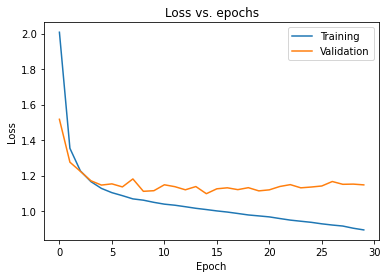

In [16]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

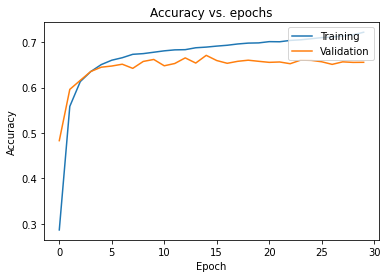

In [17]:
# Plot the training and validation loss

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [18]:
def get_model_cnn(input_shape):
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3),activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),    
        BatchNormalization(), 
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dropout(0.5),
        Dense(units=10, activation='softmax', name='dense_2')
    ])  
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return cnn_model

In [19]:
history = model.fit(X_train_mlp, y_train, epochs=30, batch_size = 64, validation_split=0.15,verbose=1, callbacks=callbacks)

Epoch 1/30
973/973 [==============================] - 12s 13ms/step - loss: 0.8512 - accuracy: 0.7342 - val_loss: 1.1586 - val_accuracy: 0.6598

Epoch 00001: val_accuracy did not improve from 0.67076
Epoch 2/30
973/973 [==============================] - 12s 13ms/step - loss: 0.8492 - accuracy: 0.7335 - val_loss: 1.1743 - val_accuracy: 0.6584

Epoch 00002: val_accuracy did not improve from 0.67076
Epoch 3/30
973/973 [==============================] - 12s 13ms/step - loss: 0.8457 - accuracy: 0.7347 - val_loss: 1.1607 - val_accuracy: 0.6585

Epoch 00003: val_accuracy did not improve from 0.67076
Epoch 4/30
973/973 [==============================] - 12s 13ms/step - loss: 0.8410 - accuracy: 0.7354 - val_loss: 1.1809 - val_accuracy: 0.6572

Epoch 00004: val_accuracy did not improve from 0.67076
Epoch 5/30
973/973 [==============================] - 12s 13ms/step - loss: 0.8342 - accuracy: 0.7382 - val_loss: 1.1963 - val_accuracy: 0.6561

Epoch 00005: val_accuracy did not improve from 0.67076


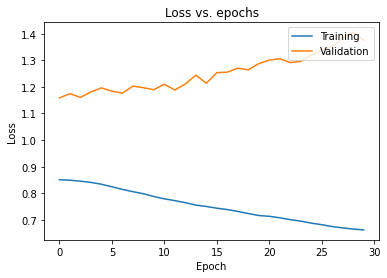

In [20]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

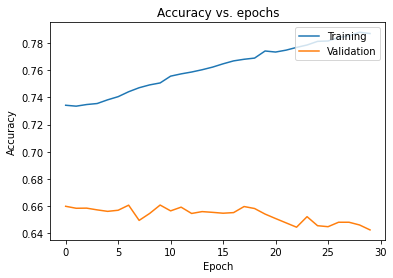

In [21]:
# Plot the training and validation loss

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.